<a href="https://colab.research.google.com/github/Txlu-OG/img_classification/blob/main/Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Classification using Random Forest with an SVM comparison

In [1]:
# Import libraries
# Core libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Image loading
from PIL import Image, UnidentifiedImageError
# ML utilities
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from sklearn.pipeline import Pipeline

In [2]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Set consistent plotting defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = False
IMG_SIZE = (64, 64)

In [4]:
# 2. Load and preprocess dataset
data_dir = '/content/drive/My Drive/images'

# Prepare containers
X, y = [], []
classes = os.listdir(data_dir)
for label in classes:
    class_dir = os.path.join(data_dir, label)
    for fname in os.listdir(class_dir):
        img = Image.open(os.path.join(class_dir, fname)).convert('RGB')
        img = img.resize((64, 64))  # Resize to uniform shape
        X.append(np.array(img).flatten())  # flatten to 1D
        y.append(label)
# Convert lists to arrays
X = np.array(X)
y = np.array(y)

In [5]:
# 3. Normalize and split dataset
X = X / 255.0

# We will keep training on string labels (y), which is fine in sklearn.
# Keep LabelEncoder only for consistent class_names and reports.
le = LabelEncoder()
le.fit(y)
class_names = list(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Classes: {class_names}")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Classes: [np.str_('dalmatian'), np.str_('dollar_bill'), np.str_('pizza'), np.str_('soccer_ball'), np.str_('sunflower')]
Train shape: (247, 12288) Test shape: (62, 12288)


In [6]:
# 4. GridSearchCV for RandomForest
# -------- 3) Random Forest with GridSearchCV --------
# Define a Random Forest classifier. n_jobs=-1 uses all available CPU cores.
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Hyperparameter grid for tuning
param_grid = {
    "n_estimators": [100, 200],       # number of trees
    "max_depth": [10, 20, None],      # tree depth limit
    "min_samples_split": [2, 5],      # split threshold
    "min_samples_leaf": [1, 2],       # leaf threshold
}

# Grid search cross validation to find best hyperparameters using accuracy
gs_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)

# Fit on training data only
gs_rf.fit(X_train, y_train)

# Best tuned Random Forest model
best_rf = gs_rf.best_estimator_
print("Best RF params:", gs_rf.best_params_)

Best RF params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


RF Accuracy: 0.8065  Precision: 0.8419  Recall: 0.8065  F1: 0.8039

Classification Report (RF):
               precision    recall  f1-score   support

   dalmatian       0.67      1.00      0.80        14
 dollar_bill       0.90      0.90      0.90        10
       pizza       0.70      0.70      0.70        10
 soccer_ball       1.00      0.55      0.71        11
   sunflower       0.93      0.82      0.88        17

    accuracy                           0.81        62
   macro avg       0.84      0.79      0.80        62
weighted avg       0.84      0.81      0.80        62



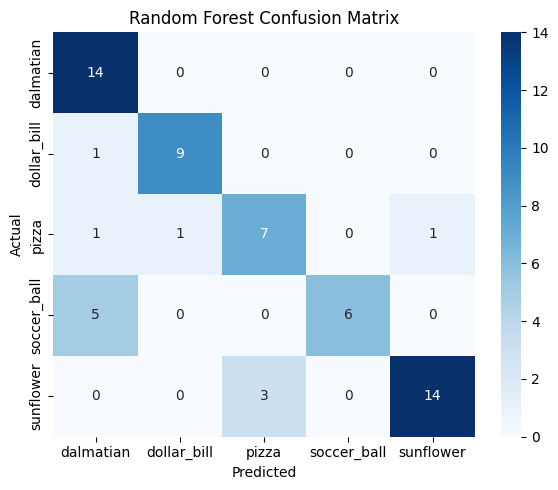

In [7]:
# -------- 4) Evaluate Random Forest --------
# Predict on holdout test set
y_pred = best_rf.predict(X_test)

# Compute standard metrics
acc = accuracy_score(y_test, y_pred)
pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)

print(f"RF Accuracy: {acc:.4f}  Precision: {pr:.4f}  Recall: {rc:.4f}  F1: {f1:.4f}")
print("\nClassification Report (RF):\n",
      classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

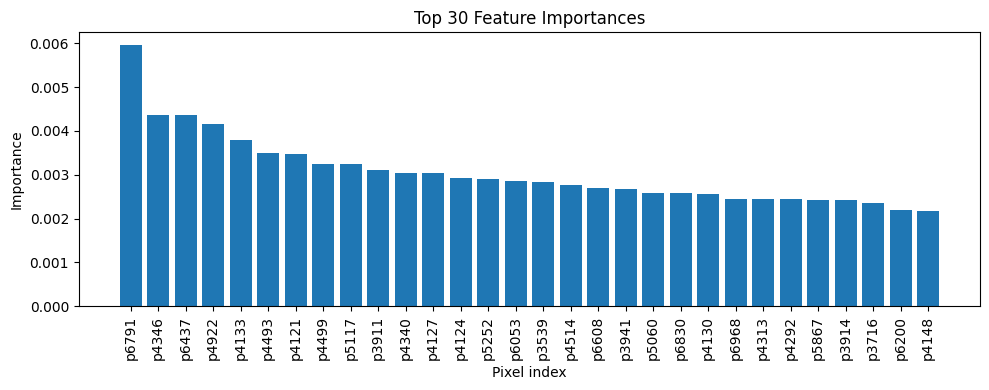

In [8]:
# 6. Feature Importance
# Random Forest provides a feature_importances_ attribute.
# Since features are pixels, importances correspond to pixel positions.
importances = best_rf.feature_importances_

# Show top N most important pixels
topN = 30
idx = np.argsort(importances)[::-1][:topN]

plt.figure(figsize=(10, 4))
plt.bar(range(topN), importances[idx])
plt.xticks(range(topN), [f"p{j}" for j in idx], rotation=90)
plt.title(f"Top {topN} Feature Importances")
plt.xlabel("Pixel index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [19]:
# -------- 6) Predict on a new image (reusable helper) --------
def preprocess_image_to_row(img_path, img_size=IMG_SIZE):
    """
    Load a single image file, convert to RGB, resize, normalize to [0,1],
    flatten to a 1xD row suitable for model.predict.
    """
    img = Image.open(img_path).convert("RGB").resize(img_size)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr.flatten().reshape(1, -1)

def classify_new_image(img_path, model, encoder=None, img_size=(64, 64)):
    """Predict class for a new image.
    - If model returns ints and you pass a fitted LabelEncoder, it will map to names.
    - If model returns strings, it just returns them.
    """
    img = Image.open(img_path).convert("RGB").resize(img_size)
    arr = (np.asarray(img, dtype=np.float32) / 255.0).flatten().reshape(1, -1)
    pred = model.predict(arr)[0]

    # If prediction is an integer and LabelEncoder is provided, map it.
    if isinstance(pred, (int, np.integer)) and encoder is not None:
        pred = encoder.inverse_transform([pred])[0]

    print(f"Predicted class for '{os.path.basename(img_path)}': {pred}")
    return pred


# Example call (uncomment and set a real path to test):
classify_new_image("/content/drive/My Drive/Copy of image_0002 (1).jpg", best_rf)

Predicted class for 'Copy of image_0002 (1).jpg': sunflower


np.str_('sunflower')

Best SVM params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
SVM Accuracy: 0.8710  Precision: 0.8748  Recall: 0.8710  F1: 0.8698

Classification Report (SVM):
               precision    recall  f1-score   support

   dalmatian       0.81      0.93      0.87        14
 dollar_bill       1.00      0.90      0.95        10
       pizza       0.88      0.70      0.78        10
 soccer_ball       0.82      0.82      0.82        11
   sunflower       0.89      0.94      0.91        17

    accuracy                           0.87        62
   macro avg       0.88      0.86      0.86        62
weighted avg       0.87      0.87      0.87        62



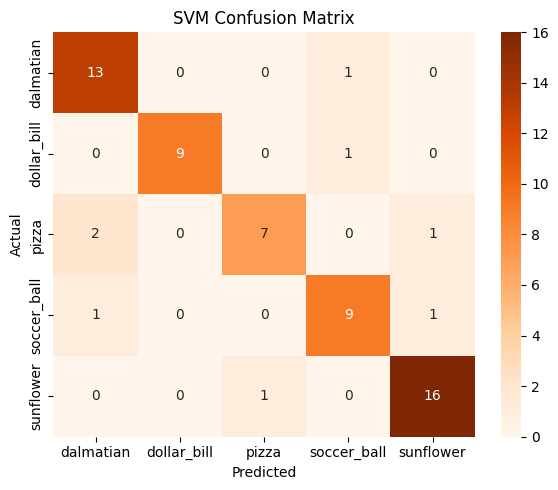

In [20]:
# SVM benefits from feature scaling. Wrap in a Pipeline with StandardScaler.
svm_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("svc", SVC())  # default uses RBF kernel when kernel="rbf"
])

# Simple SVM grid for C and kernel. Gamma='scale' is a good default.
svm_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale"],
}

# Grid search on SVM pipeline
gs_svm = GridSearchCV(
    estimator=svm_pipe,
    param_grid=svm_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)

# Fit on training data only
gs_svm.fit(X_train, y_train)

# Best tuned SVM model
best_svm = gs_svm.best_estimator_
print("Best SVM params:", gs_svm.best_params_)

# Evaluate SVM on test set
y_pred_svm = best_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
pr_svm, rc_svm, f1_svm, _ = precision_recall_fscore_support(y_test, y_pred_svm, average="weighted", zero_division=0)

print(f"SVM Accuracy: {acc_svm:.4f}  Precision: {pr_svm:.4f}  Recall: {rc_svm:.4f}  F1: {f1_svm:.4f}")
print("\nClassification Report (SVM):\n",
      classification_report(y_test, y_pred_svm, target_names=class_names, zero_division=0))

# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.tight_layout()
plt.show()

In [21]:
# Quick head to head metric table
# Small summary to compare models at a glance
summary = pd.DataFrame({
    "Model": ["Random Forest", "SVM"],
    "Accuracy": [acc, acc_svm],
    "Precision_weighted": [pr, pr_svm],
    "Recall_weighted": [rc, rc_svm],
    "F1_weighted": [f1, f1_svm],
}).round(4)

print(summary)

           Model  Accuracy  Precision_weighted  Recall_weighted  F1_weighted
0  Random Forest    0.8065              0.8419           0.8065       0.8039
1            SVM    0.8710              0.8748           0.8710       0.8698
